<a href="https://colab.research.google.com/github/tarzan03/instacart_market_basket_analysis/blob/master/instacart_market_basket_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/instacart-market-basket-analysis(1).zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(123)

# Loading the dataset.

In [0]:
prior = pd.read_csv('/tmp/order_products__prior.csv',dtype = {'order_id': np.uint32,
           'product_id': np.uint16, 'reordered': np.uint8, 'add_to_cart_order': np.uint8}) 


train_orders = pd.read_csv('/tmp/order_products__train.csv', dtype={'order_id': np.uint32,
           'product_id': np.uint16, 'reordered': np.int8, 'add_to_cart_order': np.uint8 })


orders = pd.read_csv('/tmp/orders.csv', dtype={'order_hour_of_day': np.uint8,
           'order_number': np.uint8, 'order_id': np.uint32, 'user_id': np.uint32,
           'order_dow': np.uint8, 'days_since_prior_order': np.float16})


orders.eval_set = orders.eval_set.replace({'prior': 0, 'train': 1, 'test':2}).astype(np.uint8)

orders.days_since_prior_order = orders.days_since_prior_order.fillna(30).astype(np.uint8)


products = pd.read_csv('/tmp/products.csv', dtype={'product_id': np.uint16,
            'aisle_id': np.uint8, 'department_id': np.uint8},
             usecols=['product_id', 'aisle_id', 'department_id'])

In [4]:

prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
train_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,0,1,2,8,30
1,2398795,1,0,2,3,7,15
2,473747,1,0,3,3,12,21
3,2254736,1,0,4,4,7,29
4,431534,1,0,5,4,15,28


In [7]:
products.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


# Merging prior and orders to keep the train seperate.



In [0]:
import gc

In [9]:
orders_products = orders.merge(prior, how = 'inner', on = 'order_id')
train_orders = train_orders.merge(orders[['user_id','order_id']], left_on = 'order_id', right_on = 'order_id', how = 'inner')

del prior
gc.collect()

94

In [10]:
train_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id
0,1,49302,1,1,112108
1,1,11109,2,1,112108
2,1,10246,3,0,112108
3,1,49683,4,0,112108
4,1,43633,5,1,112108


In [11]:
orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,0,1,2,8,30,196,1,0
1,2539329,1,0,1,2,8,30,14084,2,0
2,2539329,1,0,1,2,8,30,12427,3,0
3,2539329,1,0,1,2,8,30,26088,4,0
4,2539329,1,0,1,2,8,30,26405,5,0


In [12]:
#Creating the features.
prdss = orders_products.sort_values(['user_id', 'order_number', 'product_id'], ascending = True)
prdss['product_time'] = prdss.groupby(['user_id', 'product_id']).cumcount()+1

# getting products ordered first and second times to calculate probability later

sub1 = prdss[prdss['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')

sub2 = prdss[prdss['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')

sub1['prod_orders'] = prdss.groupby('product_id')['product_id'].size()

sub1['prod_reorders'] = prdss.groupby('product_id')['reordered'].sum()

sub2 = sub2.reset_index().merge(sub1.reset_index())

sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']

sub2['prod_reorder_ratio'] = sub2['prod_reorders']/sub2['prod_orders']

prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_ratio']]

del sub1, sub2, prdss
gc.collect()

156

In [13]:
prd.head()

,product_id,prod_orders,prod_reorder_probability,prod_reorder_ratio
0,1,1852,0.385475,0.613391
1,2,90,0.102564,0.133333
2,3,277,0.486486,0.732852
3,4,329,0.351648,0.446809
4,5,15,0.666667,0.600000


In [14]:
# extracting prior information (features) by user
users = orders[orders['eval_set'] == 0].groupby(['user_id'])['order_number'].max().to_frame('user_orders')
users['user_period'] = orders[orders['eval_set'] == 0].groupby(['user_id'])['days_since_prior_order'].sum()
users['user_mean_days_since_prior'] = orders[orders['eval_set'] == 0].groupby(['user_id'])['days_since_prior_order'].mean()

# merging features about users and orders into one dataset
us = orders_products.groupby('user_id').size().to_frame('user_total_products')
us['eq_1'] = orders_products[orders_products['reordered'] == 1].groupby('user_id')['product_id'].size()
us['gt_1'] = orders_products[orders_products['order_number'] > 1].groupby('user_id')['product_id'].size()
us['user_reorder_ratio'] = us['eq_1'] / us['gt_1']
us.drop(['eq_1', 'gt_1'], axis = 1, inplace = True)
us['user_distinct_products'] = orders_products.groupby(['user_id'])['product_id'].nunique()

# the average basket size of the user
users = users.reset_index().merge(us.reset_index())
users['user_average_basket'] = users['user_total_products'] / users['user_orders']

us = orders[orders['eval_set'] != 0]
us = us[['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
users = users.merge(us)

del us
gc.collect()

175

In [15]:
users.head()

,user_id,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order
0,1,10,206.0,20.600000,59,0.759259,18,5.900000,1187899,1,14
1,2,14,228.0,16.285714,195,0.510989,102,13.928571,1492625,1,30
2,3,12,163.0,13.583333,88,0.705128,33,7.333333,2774568,2,11
3,4,5,85.0,17.000000,18,0.071429,17,3.600000,329954,2,30
4,5,4,70.0,17.500000,37,0.538462,23,9.250000,2196797,1,6


In [16]:
# merging orders and products and grouping by user and product and calculating features for the user/product combination
data = orders_products.groupby(['user_id', 'product_id']).size().to_frame('up_orders')
data['up_first_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].min()
data['up_last_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].max()
data['up_average_cart_position'] = orders_products.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()
data = data.reset_index()

#merging previous data with users
data = data.merge(prd, on = 'product_id')
data = data.merge(users, on = 'user_id')

#user/product combination features about the particular order
data['up_order_rate'] = data['up_orders'] / data['user_orders']
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order']
data = data.merge(train_orders[['user_id', 'product_id', 'reordered']], 
                  how = 'left', on = ['user_id', 'product_id'])
data = data.merge(products, on = 'product_id')

del orders_products     #orders, train_orders
gc.collect()

91

In [17]:
data.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_ratio,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,reordered,aisle_id,department_id
0,1,196,10,1,10,1.400000,35791,0.5825,0.77648,10,206.0,20.600000,59,0.759259,18,5.900000,1187899,1,14,1.000000,0,1.0,77,7
1,15,196,5,15,22,2.200000,35791,0.5825,0.77648,22,257.0,11.681818,72,0.867647,13,3.272727,2161313,2,7,0.227273,0,NaN,77,7
2,19,196,3,2,7,6.333333,35791,0.5825,0.77648,9,106.0,11.777778,204,0.412791,133,22.666667,1735923,2,8,0.333333,2,NaN,77,7
3,21,196,1,10,10,2.000000,35791,0.5825,0.77648,33,347.0,10.515152,205,0.515000,102,6.212121,1854765,1,28,0.030303,23,NaN,77,7
4,31,196,2,10,17,15.500000,35791,0.5825,0.77648,20,123.0,6.150000,299,0.381119,190,14.950000,280888,2,18,0.100000,3,NaN,77,7


In [18]:
#save the actual reordered products of the train set in a list format and then delete the original frames
train_orders = train_orders[train_orders['reordered']==1].drop('reordered',axis=1)
orders.set_index('order_id', drop=False, inplace=True)
train1=orders[['order_id','eval_set']].loc[orders['eval_set']==1]
train1['actual'] = train_orders.groupby('order_id').aggregate({'product_id':lambda x: list(x)})
train1['actual']=train1['actual'].fillna('')
n_actual = train1['actual'].apply(lambda x: len(x)).mean()   # this is the average cart size

test1=orders[['order_id','eval_set']].loc[orders['eval_set']==2]
test1['actual']=' '
traintest1=pd.concat([train1,test1])
traintest1.set_index('order_id', drop=False, inplace=True)

del orders, train_orders, train1, test1
gc.collect()

14

In [19]:
traintest1.head()

,order_id,eval_set,actual
order_id,,,
1187899,1187899,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1492625,1492625,1,"[22963, 7963, 16589, 32792, 41787, 22825, 2485..."
2196797,2196797,1,"[15349, 21413, 40706, 21616]"
525192,525192,1,"[47272, 37999, 13198, 43967, 40852, 17638, 298..."
880375,880375,1,"[15937, 23165, 21903, 41540]"


In [20]:
#reduce the size by setting data types
data = data.astype(dtype= {'user_id' : np.uint32, 'product_id'  : np.uint16,
            'up_orders'  : np.uint8, 'up_first_order' : np.uint8, 'up_last_order' : np.uint8,
            'up_average_cart_position' : np.uint8, 'prod_orders' : np.uint16, 
            'prod_reorder_probability' : np.float16,   
            'prod_reorder_ratio' : np.float16, 'user_orders' : np.uint8,
            'user_period' : np.uint8, 'user_mean_days_since_prior' : np.uint8,
            'user_total_products' : np.uint8, 'user_reorder_ratio' : np.float16, 
            'user_distinct_products' : np.uint8, 'user_average_basket' : np.uint8,
            'order_id'  : np.uint32, 'eval_set' : np.uint8, 
            'days_since_prior_order' : np.uint8, 'up_order_rate' : np.float16, 
            'up_orders_since_last_order':np.uint8,
            'aisle_id': np.uint8, 'department_id': np.uint8})

data['reordered'].fillna(0, inplace=True)  # replace NaN with zeros (not reordered) 
data['reordered']=data['reordered'].astype(np.uint8)

gc.collect()

0

In [21]:
# filter by eval_set (train=1, test=2) and dropp the id's columns (not part of training features) 
# but keep prod_id and user_id in test

train = data[data['eval_set'] == 1].drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis = 1)
test =  data[data['eval_set'] == 2].drop(['eval_set', 'user_id', 'reordered'], axis = 1)

check =  data.drop(['eval_set', 'user_id', 'reordered'], axis = 1)

del data
gc.collect()

0

In [22]:
train.columns

Index(['up_orders', 'up_first_order', 'up_last_order',
       'up_average_cart_position', 'prod_orders', 'prod_reorder_probability',
       'prod_reorder_ratio', 'user_orders', 'user_period',
       'user_mean_days_since_prior', 'user_total_products',
       'user_reorder_ratio', 'user_distinct_products', 'user_average_basket',
       'days_since_prior_order', 'up_order_rate', 'up_orders_since_last_order',
       'reordered', 'aisle_id', 'department_id'],
      dtype='object')

In [0]:
fc = tf.feature_column

features = ['up_orders', 'up_first_order', 'up_last_order',
        'up_average_cart_position', 'prod_orders', 'prod_reorder_probability',
        'prod_reorder_ratio', 'user_orders', 'user_period',
        'user_mean_days_since_prior', 'user_total_products',
        'user_reorder_ratio', 'user_distinct_products', 'user_average_basket',
        'days_since_prior_order', 'up_order_rate', 'up_orders_since_last_order',
         'aisle_id', 'department_id']

feature_columns = []


for feature_name in features:
  feature_columns.append(fc.numeric_column(feature_name,dtype = tf.float16))


In [0]:
#??tf.feature_column

In [25]:
test.columns

Index(['product_id', 'up_orders', 'up_first_order', 'up_last_order',
       'up_average_cart_position', 'prod_orders', 'prod_reorder_probability',
       'prod_reorder_ratio', 'user_orders', 'user_period',
       'user_mean_days_since_prior', 'user_total_products',
       'user_reorder_ratio', 'user_distinct_products', 'user_average_basket',
       'order_id', 'days_since_prior_order', 'up_order_rate',
       'up_orders_since_last_order', 'aisle_id', 'department_id'],
      dtype='object')

In [0]:
#train = train[0:1000000]

In [0]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_eval, y_train, y_eval = train_test_split(
    train[train.columns.difference(['reordered'])], train['reordered'], test_size=0.4, random_state=2)

del train
gc.collect()

10

In [29]:
X_train.shape,X_eval.shape,y_train.shape,y_eval.shape

((5073441, 19), (3382294, 19), (5073441,), (3382294,))

In [0]:
NUM_EXAMPLES = len(y_train[:10000])

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES)) 
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(X_train, y_train)
eval_input_fn = make_input_fn(X_eval, y_eval, shuffle=False, n_epochs=1)


In [31]:
params = {
  'n_trees': 20,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to 
  # make an initial prediction before using any features (e.g. use the mean of 
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
est.train(train_input_fn, max_steps=100)
results = est.evaluate(eval_input_fn)
pd.Series(results).to_frame()


,0
accuracy,0.907559
accuracy_baseline,0.902193
auc,0.823229
auc_precision_recall,0.391689
average_loss,0.251744
label/mean,0.097807
loss,0.251706
precision,0.604855
prediction/mean,0.098856
recall,0.158235


In [32]:
def make_inmemory_train_input_fn(X, y):
  def input_fn():
    return dict(X), y
  return input_fn


train_input_fn = make_inmemory_train_input_fn(X_train, y_train)
eval_input_fn = make_input_fn(X_eval, y_eval, shuffle=False, n_epochs=5)
est = tf.contrib.estimator.boosted_trees_classifier_train_in_memory(
    train_input_fn,
    feature_columns)
print(est.evaluate(eval_input_fn)['accuracy'])


0.90952086


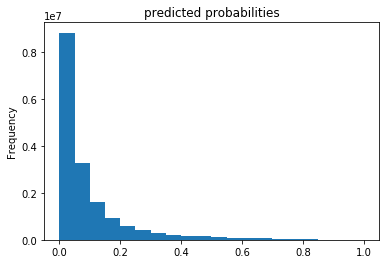

In [33]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities');
